# Data Challenge
autor: [Joaquin Menendez](https://www.linkedin.com/in/joaquin-menendez/) <br>
email: [joaquin14@gmail.com](mailto:joaquin14@gmail.com)

In [1]:
import requests
import pandas as pd
import numpy as np
from decouple import config
import pickle
import matplotlib.pyplot as plt
import seaborn as sbn
import plotly
import plotly.express as px

Importamos un módulo con funciones útiles para interactuar con las requests. Este módulo asume la prescencia de un archivo `.env` con las keys para hacer request a una API. Si experimenta algún problema fijese de tener este archivo.

In [2]:
from melitools import get_category_country_list, basic_df, mapper_currency

Confugraciones inciales

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plotly.offline.init_notebook_mode(connected=True)

## Explorando la API de MELI

Vamos a explorar cuales son los diferentes sites o países en los cuales opera MELI.

In [4]:
sites = requests.get('https://api.mercadolibre.com/sites/').json()
sites = pd.DataFrame(sites)
sites

,default_currency_id,id,name
0,PEN,MPE,Perú
1,VES,MLV,Venezuela
2,UYU,MLU,Uruguay
3,USD,MEC,Ecuador
4,CLP,MLC,Chile
5,HNL,MHN,Honduras
6,DOP,MRD,Dominicana
7,ARS,MLA,Argentina
8,COP,MCO,Colombia
9,NIO,MNI,Nicaragua


VEmos que tenemos 18 paises con diferentes divisas, para poder hacer una comparación entre paises necesitaremos convertir los precios a un precio común, en este caso USD.

Vamos a ver las diferentes categorías generales que podemos encontrar. Vamos a consultar en el site de Argnetina dado que es el país que elegiremos para nuestro modelo de ML más adelante.

In [6]:
categories = requests.get('https://api.mercadolibre.com/sites/MLA/categories').json()
print(len(categories))
categories

31


[{'id': 'MLA5725', 'name': 'Accesorios para Vehículos'},
 {'id': 'MLA1512', 'name': 'Agro'},
 {'id': 'MLA1403', 'name': 'Alimentos y Bebidas'},
 {'id': 'MLA1071', 'name': 'Animales y Mascotas'},
 {'id': 'MLA1367', 'name': 'Antigüedades y Colecciones'},
 {'id': 'MLA1368', 'name': 'Arte, Librería y Mercería'},
 {'id': 'MLA1743', 'name': 'Autos, Motos y Otros'},
 {'id': 'MLA1384', 'name': 'Bebés'},
 {'id': 'MLA1246', 'name': 'Belleza y Cuidado Personal'},
 {'id': 'MLA1039', 'name': 'Cámaras y Accesorios'},
 {'id': 'MLA1051', 'name': 'Celulares y Teléfonos'},
 {'id': 'MLA1648', 'name': 'Computación'},
 {'id': 'MLA1144', 'name': 'Consolas y Videojuegos'},
 {'id': 'MLA1276', 'name': 'Deportes y Fitness'},
 {'id': 'MLA5726', 'name': 'Electrodomésticos y Aires Ac.'},
 {'id': 'MLA1000', 'name': 'Electrónica, Audio y Video'},
 {'id': 'MLA2547', 'name': 'Entradas para Eventos'},
 {'id': 'MLA407134', 'name': 'Herramientas y Construcción'},
 {'id': 'MLA1574', 'name': 'Hogar, Muebles y Jardín'},
 {'

In [7]:
# Vamos a explorar "Celulares y Télefonos"
requests.get('https://api.mercadolibre.com/categories/MLA1051').json()['children_categories']

[{'id': 'MLA3502',
  'name': 'Accesorios para Celulares',
  'total_items_in_this_category': 282171},
 {'id': 'MLA1055',
  'name': 'Celulares y Smartphones',
  'total_items_in_this_category': 74101},
 {'id': 'MLA1058',
  'name': 'Handies y Radiofrecuencia',
  'total_items_in_this_category': 9580},
 {'id': 'MLA401278',
  'name': 'Lentes de Realidad Virtual',
  'total_items_in_this_category': 1381},
 {'id': 'MLA3813',
  'name': 'Repuestos de Celulares',
  'total_items_in_this_category': 60561},
 {'id': 'MLA417704',
  'name': 'Smartwatches y Accesorios',
  'total_items_in_this_category': 14292},
 {'id': 'MLA10616',
  'name': 'Tarifadores y Cabinas',
  'total_items_in_this_category': 177},
 {'id': 'MLA1053',
  'name': 'Telefonía Fija e Inalámbrica',
  'total_items_in_this_category': 14804},
 {'id': 'MLA5237',
  'name': 'Telefonía IP',
  'total_items_in_this_category': 2362},
 {'id': 'MLA1915', 'name': 'Otros', 'total_items_in_this_category': 2892}]

Se decidió explorar el rubro de `Celulares y Teléfonos`, mas puntualmente el subgrupo de `Celulares y Smartphones`.

Considero que estos items son interesantes dado que presentan un alto volumen de venta, aproximadamente 130 millones de unidades vendidas por año en Latinoamerica ([link](https://www.statista.com/statistics/826506/smartphone-unit-sales-latin-america/)). <br>

Al mismo tiempo las características físicas de estos elementos permiten no necesitar un gran deposito para guardar el stock por parte del vendedor. Dada la reciente pandemia muchos comerciantes optaron por no cargar con gastos honerosos como puede ser tener un local que de a la calle. Si observamos que países presentan un mercado qué aun no ha explotado, podria intentar realizarse una campaña de marketing focalizada especificamente para subgrupo.

In [8]:
cels_smart_code = "1055" # El código es igual a todos los paises, solo debe agregar el `site_it` de cada país.

## Extrayendo la data

**ATENCION!!** <br>
El presente notebook realiza conlcusiones en base a datos tomados el dia 02/03/2020.<br>
Es probable que si usted crealiza una nueva consulta, los resultados puedan diferir ligeramente.
Si desea ahorrarse el tiempo y cargar una request guardada por favor seleccione dicha opción en la siguiente cell. Sino se procederá a consultar nuevamente a la base de datos.

In [10]:
# Guardamos todos los results de nuestra query en una lista.
cargar = ''
while cargar == '':
    cargar = str(input('Si desea cargar el dataset ingrese la letra "y": '))
    if cargar == "y":
        print('Cargando consulta antigua...')
        with open('data/results_countries.pkl','rb') as file:
            results_countries= pickle.load(file)
    elif cargar != '':
        print('Realizando nueva consulta...')
        results_countries = get_category_country_list(sites.id, cels_smart_code, limit = 20)

Si desea cargar el dataset ingrese la letra "y": y
Cargando consulta antigua...


A continuación convertimos la consulta en un DataFrame para poder explorarlo, esto puede demorar.
Si desea ver como se está haciendo esto puede consultar la función `basic_df`.

In [68]:
# Vamos a crear un DF básico con algunas features generales de nuestro interes
features = ['id', 'site_id', 'price', 'original_price', 'category_id',
 'condition', 'sold_quantity', 'available_quantity', 'currency_id']
# Agregamos atributos específicos como Marca y Modelo de celular
attributes = ['BRAND','MODEL']
#Usamos una función de nuestro módulo melitools
df_countries = basic_df(results=results_countries, features=features, attributes=attributes)

In [69]:
df_countries

,id,site_id,price,original_price,category_id,condition,sold_quantity,available_quantity,currency_id,BRAND,MODEL
0,MRD414086101,MRD,55000.00,None,MRD1055,new,500,500,DOP,Apple,iPhone 12 Pro
1,MRD414086104,MRD,18000.00,None,MRD1055,new,500,250,DOP,Apple,iPhone XS Max
2,MRD414086110,MRD,35000.00,None,MRD1055,new,500,500,DOP,Apple,iPhone 11 Pro Max
3,MRD414003504,MRD,18500.00,None,MRD1055,new,500,500,DOP,Apple,iPhone XS Max
4,MRD414079831,MRD,13500.00,None,MRD1055,new,5000,250,DOP,Apple,iPhone 8 Plus
...,...,...,...,...,...,...,...,...,...,...,...
12764,MPA401906334,MPA,160.00,None,MPA1055,new,5,1,USD,Samsung,A30 Duos
12765,MPA401906305,MPA,120.00,None,MPA1055,new,50,1,USD,Samsung,A20s Duos
12766,MPA401902896,MPA,320.00,None,MPA1055,new,0,50,USD,Samsung,S10+
12767,MPA401903262,MPA,589.99,None,MPA1055,new,0,1,USD,Apple,iPhone 12 Pro Max


In [70]:
# Agregamos país al DF de una manera que sea más legible que el `site_id`
df_countries['country'] = df_countries.site_id.map(mapper_country)

### Creando algunos features

In [71]:
# Precio en USD
df_countries['price_USD'] = df_countries.apply(lambda row: row.price/mapper_currency[row.currency_id] 
                                                           if row.currency_id != 'USD'
                                                           else row.price , axis = 1)

In [72]:
#Descuento
df_countries['discount'] = 1
df_countries.loc[df_countries.original_price.isna(),'discount'] = 0  # Si original_price is null entonces no tiene

In [73]:
# Descuentos en pesos
df_countries['descuento_precio'] = df_countries.apply(lambda row: row.original_price - row.price 
                                                      if row.discount == 1
                                                      else 0, axis = 1)

In [74]:
# Descuento en dolares
df_countries['descuento_USD'] = df_countries.apply(lambda row: row.descuento_precio/mapper_currency[row.currency_id]
                                                               if row.currency_id != 'USD'
                                                               else row.descuento_precio , axis = 1)

### Chequeando nuestro dataset
Vamos a observar si los precios transformados tienen coherencia

In [75]:
df_countries.describe()

,price,sold_quantity,available_quantity,price_USD,discount,descuento_precio,descuento_USD
count,12769.00,12769.00,12769.00,12769.00,12769.00,12769.00,12769.00
mean,19361199.72,56.42,152.78,344.11,0.09,14742.83,6.93
std,109202501.87,337.92,1071.18,1293.76,0.28,596723.60,32.85
min,0.60,0.00,1.00,0.00,0.00,0.00,0.00
25%,779.00,0.00,1.00,125.00,0.00,0.00,0.00
50%,5000.00,4.00,1.00,237.32,0.00,0.00,0.00
75%,145000.00,5.00,50.00,391.80,0.00,0.00,0.00
max,3242400000.00,8975.00,50000.00,139999.00,1.00,38779232.00,654.75


Si bien una mediana de 250 USD tienen coherencia para el mercado Latinoamericano, no asi los valores mínimos y máximos

In [76]:
df_countries.sort_values('price_USD')[:20]

,id,site_id,price,original_price,category_id,condition,sold_quantity,available_quantity,currency_id,BRAND,MODEL,country,price_USD,discount,descuento_precio,descuento_USD
10770,MCR425296454,MCR,1.00,None,MCR1055,used,4,5000,CRC,Samsung,A71,Costa Rica,0.00,0,0.00,0.00
11032,MCR425258963,MCR,1.00,None,MCR1055,used,0,50,CRC,Apple,iPhone XR,Costa Rica,0.00,0,0.00,0.00
10674,MCR425243032,MCR,1.00,None,MCR1055,used,3,1,CRC,None,None,Costa Rica,0.00,0,0.00,0.00
11082,MCR425293976,MCR,1.00,None,MCR1055,used,5,150,CRC,Apple,iPhone 8,Costa Rica,0.00,0,0.00,0.00
10575,MCR425256229,MCR,1.00,None,MCR1055,used,0,1,CRC,Xiaomi,Note 9,Costa Rica,0.00,0,0.00,0.00
10727,MCR425296450,MCR,1.00,None,MCR1055,used,0,1,CRC,Apple,iPhone 11 Pro Max,Costa Rica,0.00,0,0.00,0.00
11060,MCR425266975,MCR,3.00,None,MCR1055,used,0,1,CRC,Apple,iPhone,Costa Rica,0.00,0,0.00,0.00
704,MRD414106084,MRD,1.00,None,MRD1055,new,0,1,DOP,Apple,iPhone,Dominicana,0.02,0,0.00,0.00
855,MRD414061723,MRD,1.00,None,MRD1055,used,0,1,DOP,Apple,iPhone X,Dominicana,0.02,0,0.00,0.00
790,MRD414122595,MRD,1.00,None,MRD1055,used,0,1,DOP,Samsung,A10s,Dominicana,0.02,0,0.00,0.00


Algo raro esta pasando en Paraguay, Costa Rica y Dominicana

Parece que por alguna razón los precios en Paraguay estan expresados como pesos paraguayos cuando en realidad deberían ser dolares (300 pesos paraguayos no es posible para un Xiaomi nuevo, pero 300 dolares es un poco más plausible).<br>
El problema debe ser desde al momento de la carga por los mismos usuarios (quizas pusieron su moneda local en vez de dólares) o quizás haya algún comportamiento que no estemos observando (quizás publican barato para lograr publicidad gratis hacia páginas personales). 

Vamos a eliminar estos casos más adelante.

In [77]:
df_countries.sort_values('price_USD')[-10:]

,id,site_id,price,original_price,category_id,condition,sold_quantity,available_quantity,currency_id,BRAND,MODEL,country,price_USD,discount,descuento_precio,descuento_USD
5085,MLA898795478,MLA,299999.00,None,MLA1055,new,0,1,ARS,Apple,iPhone 11 Pro Max,Argentina,3325.04,0,0.00,0.00
5080,MLA897416553,MLA,307990.00,None,MLA1055,new,1,100,ARS,Apple,iPhone 12 Pro Max,Argentina,3413.61,0,0.00,0.00
5978,MLA902681740,MLA,310000.00,None,MLA1055,new,4,50,ARS,Apple,iPhone 12 Pro,Argentina,3435.89,0,0.00,0.00
5578,MLA871664484,MLA,359999.10,None,MLA1055,new,3,1,ARS,Apple,iPhone 11 Pro Max,Argentina,3990.05,0,0.00,0.00
5652,MLA885327167,MLA,395000.00,None,MLA1055,new,0,1,ARS,Apple,iPhone 12 Pro Max,Argentina,4377.99,0,0.00,0.00
5077,MLA820015142,MLA,399999.00,None,MLA1055,new,0,1,ARS,Apple,iPhone 7 Plus,Argentina,4433.39,0,0.00,0.00
5081,MLA886301157,MLA,399999.00,None,MLA1055,new,0,1,ARS,Apple,iPhone 8,Argentina,4433.39,0,0.00,0.00
5100,MLA886300448,MLA,450000.00,None,MLA1055,new,0,1,ARS,Apple,iPhone 8 Plus,Argentina,4987.58,0,0.00,0.00
215,MRD413920023,MRD,17490.00,None,MRD1055,new,2,500,USD,Xiaomi,Xiaomi Mi Note 10 Pro,Dominicana,17490.00,0,0.00,0.00
11351,MEC429804060,MEC,139999.00,None,MEC1055,new,500,500,USD,Samsung,A01 A10S A11 A20S A30S A51 A71 A31 l3150 4160 ...,Ecuador,139999.00,0,0.00,0.00


No es inusual encontrar que la mayoría de los valores anomalos sean de Argentina. Esto se debe a que la conversión que se realiza a dolares se hace con el dolar oficial, sin embargo como es de público conocimento Argentina tiene otra cotización, denominada "dolar blue" que es la que se toma para las transacciones entre personas.<br>
Podriamos realizar un ajuste en base a esta información, pero lo dejaremos para otra oportunidad.<br>
Los casos extremos como los de Dominicana y Ecuador pueden deberse a errores de carga, estos serán eliminados más adelante.

## Plotting

Datos provenientes de la request

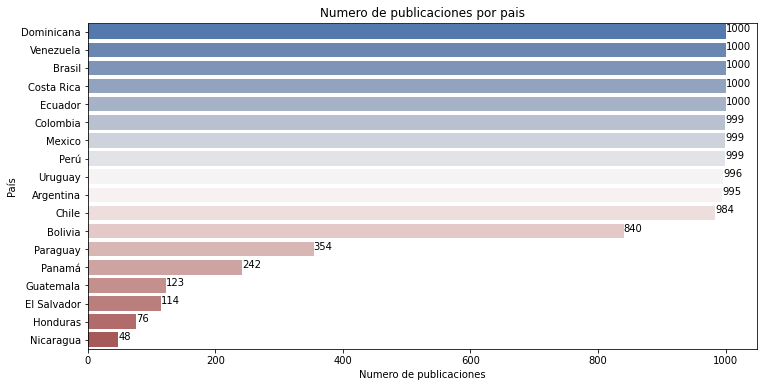

In [82]:
# Numero de casos por país
plt.figure(figsize = (12, 6))
ax = sbn.countplot(y = df_countries.country,
                   palette='vlag',
                   order = df_countries.country.value_counts().index) # Vamos a ordenarlos de mayor a menor

# Agregamos counts para facilitar la lectura
for p in ax.patches:
        numb =  p.get_width()
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(numb, (x, y))
ax.set_title('Numero de publicaciones por pais')
ax.set_xlabel('Numero de publicaciones')
ax.set_ylabel('País')
plt.show()

Este plot debe ser tomado con pinzas. La cantidad de publicaciones presentada no es un fiel estimativo de la cantidad de publicaciones por pais al momento del análisis.<br>
Dado que el limite de la query es 1000, es probable que aquellos paises con un valor de 1000, así como todos los valores cercanos a mil (i.e Peru 999, o Argentina 995) puedan deberser a algún inconveniente en la request cuando nos aproximamos a esos valores. 

Sin embargo los números que si son claros son las de aquellos paises (desde Bolivia hasta Nicaragua) en las cuales se puede asegurar que el número de publicaciones al dia de la fecha 02/03/2020 es menor a mil.

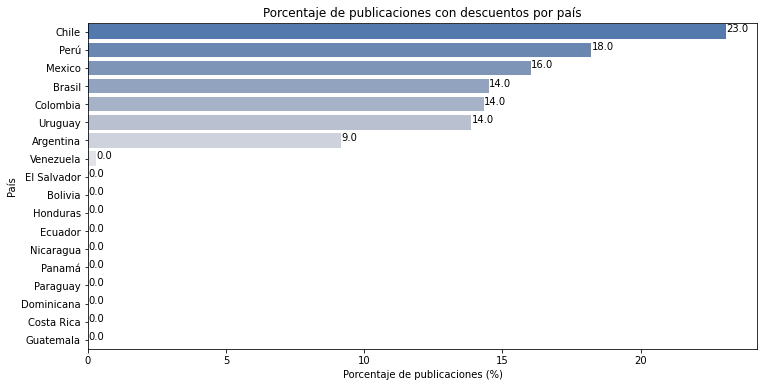

In [83]:
tmp = df_countries.groupby('country')["discount"].sum() /  df_countries.groupby('country').site_id.count() * 100
tmp = tmp.reset_index(name = "proportion_discount").sort_values('proportion_discount',ascending=False)

plt.figure(figsize = (12, 6))
ax = sbn.barplot(data = tmp, y='country', x='proportion_discount', palette= 'vlag')
for p in ax.patches:
        prop =  np.round(p.get_width(),0)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(prop, (x, y))
ax.set_title('Porcentaje de publicaciones con descuentos por país')
ax.set_xlabel('Porcentaje de publicaciones (%)')
ax.set_ylabel('País')
plt.show()

Podemos ver como son pocos los países que utilizan publicaciones con descuentos. <br>
Dentro de los mismos, Chile se presenta como el país con la mayor cantidad de ofertas.

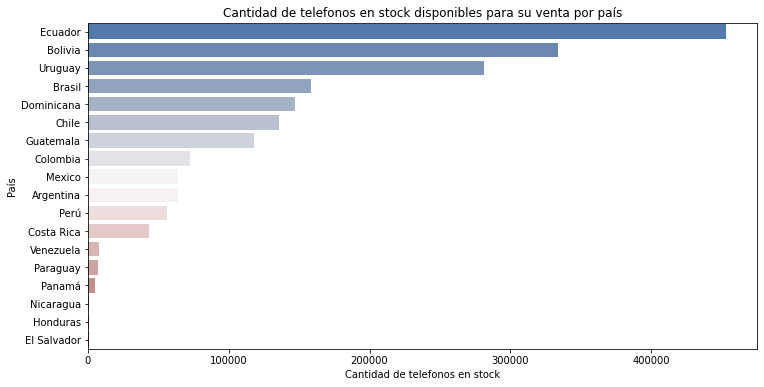

In [84]:
tmp = df_countries.groupby('country')["available_quantity"].sum().\
                                                            reset_index(name='total_available').\
                                                            sort_values('total_available', ascending=False)

plt.figure(figsize = (12, 6))
ax = sbn.barplot(data = tmp, y='country', x='total_available', palette= 'vlag') 
ax.set_title('Cantidad de telefonos en stock disponibles para su venta por país')
ax.set_xlabel('Cantidad de telefonos en stock')
ax.set_ylabel('País')
plt.show()

Llama la atención la gran cantidad de teléfonos en stock en Ecuador.<br>
Es probable que en dicho país, la venta y compra de celulares por e-commerce sea una práctica común. O puede deberse a que grandes vendedores, antes vendiendo directamente en tiendas, se hayan volcado a la venta online.

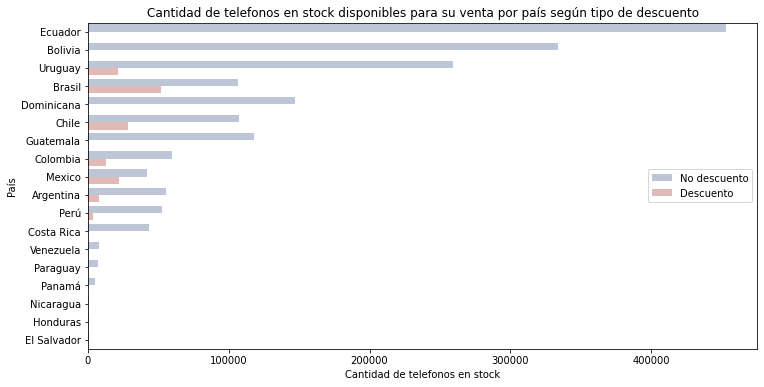

In [85]:
plt.figure(figsize = (12, 6))
ax = sbn.barplot(data = df_countries,
                 y='country',
                 x='available_quantity',
                 hue='discount',
                 ci = None,
                 estimator = sum, 
                 order = df_countries.groupby('country').available_quantity.sum().\
                                                         sort_values(ascending = False).index,
                 palette= 'vlag',
                 saturation=1
                ) 
plt.legend(['No descuento','Descuento'])
ax.set_title('Cantidad de telefonos en stock disponibles para su venta por país según tipo de descuento')
ax.set_xlabel('Cantidad de telefonos en stock')
ax.set_ylabel('País')
plt.show()

Vemos nuevamente como Chile es un mercado proclive a ofertar descuentos. Despues de Brasil, es el país con mayor cantidad de telefonos disponibles para la compra que cuentan con descuento.

### Eliminamos outliers y ploteamos los costos de publicación

Dado que no es muy factible que un teléfono valga menos de 15 USD vamos a remover estos casos.<br>
De esta manera nos librarmos de los casos etiquetados con un valor de 1 peso.

In [86]:
df = df_countries[df_countries.price_USD >= 15]
# Removemos los outliers y nos quedamos con el 95% de nuestros datos
df = df[
    (df.price_USD <= df.price_USD.quantile(0.975)) &
    (df.price_USD >= df.price_USD.quantile(0.025))
]

In [92]:
(df_countries.country.value_counts() - df.country.value_counts()).sort_values()

Honduras         0
El Salvador      2
Nicaragua        3
Panamá           4
Bolivia          7
Guatemala       16
Brasil          37
Paraguay        42
Dominicana      42
Mexico          49
Chile           65
Ecuador         70
Argentina       74
Costa Rica     101
Colombia       102
Uruguay        103
Venezuela      250
Perú           287
Name: country, dtype: int64

Los paises que más sufrieron de la remoción de outliers fueron Peru y Venezuela.<br>
Es un dato de interes para ver por qué hay tantaz publicaciones de celulares que claramente no pueden estar tan baratos.

In [87]:
# Precio promedio publicado por país
fig = px.box(df, y="price_USD", x="country",
             title= 'Mediana de precios de celulares publicados',
             labels = {
                 "price_USD": "Precio (USD $)",
                 "country": "País"
                      }
            )
fig.show()

Observamos que los menores precios corresponden a Venezuela. Esto no es sorpresivo dadala crisis económica que atravieza el país.

In [93]:
# Precio promedio publicado por país. Solo aquellos con mas de 900 publicaciones
more_900 = df.site_id.value_counts()[df.site_id.value_counts() > 900].index
fig = px.box(df[df.site_id.isin(more_900)],
             y="price_USD", x="country",
             title= 'Mediana de precios de celulares publicados (paises con mas de 900 publicaciones)',
             labels = {
                 "price_USD": "Precio (USD $)",
                 "country": "País"
                      }
            )
fig.show()

Si solo nos concentramos en los paises con mas de 900 publicaciones "normales", vemos que Ecuador presenta una gran variabilidad de precios y es el segundo país con la mayor mediana, siendo Chile el primero. 

In [31]:
# Promedio de descuento publicado
fig = px.box(df[df.discount == 1], y="descuento_USD", x="country",
             title= 'Mediana de descuento de celulares publicados',
             labels = {
                 "descuento_USD": "Descuento (USD $)",
                 "country": "País"
                      }
            )
fig.show()

Observamos nuevamente que Chile es el país que presenta una mayor mediana de descuento en sus publicaciones.

## Limitaciones

La mayoria de las inferencias realizadas son supuestos dada la limitación de 1000 resultados de cada query. Por ende estos resultados, podrían cambiar al analizar todos los datos.